<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/experiments/Notebook-Snapshots/RuntypeBERT/3.10.1%20BERT-Daju-BERT_based_NepCov19Tweets_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed
import datasets

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

# Loading Model and Tokenizer

In [23]:
from transformers import AutoConfig
from transformers import BertTokenizerFast
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast

print("Loading Model")
i = 1
model_id = ['raygx/distilBERT-Nepali','raygx/BERT-Daju','Shushant/nepaliBERT','Rajan/NepaliBERT','nowalab/nepali-bert-npvec1','NepBERTa/NepBERTa',"raygx/BertClassifier4NepaliNews"][i]

print("Intialization: Pretrained {}".format(model_id))

try:
  tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
except:
  tokenizer = BertTokenizerFast.from_pretrained(model_id)

try:
  model = TFAutoModelForSequenceClassification.from_pretrained(model_id,
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2},ignore_mismatched_sizes=True)
except Exception as e:
  print(e)
  model = TFAutoModelForSequenceClassification.from_pretrained(model_id,
            id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
            label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}, from_pt=True,ignore_mismatched_sizes=True)
model.resize_token_embeddings(len(tokenizer))

Loading Model
Intialization: Pretrained raygx/BERT-Daju


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at raygx/BERT-Daju and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<tf.Variable 'tf_bert_for_sequence_classification_1/bert/embeddings/word_embeddings/weight:0' shape=(50000, 768) dtype=float32, numpy=
array([[-0.01297948,  0.61530435, -0.02285126, ..., -0.03573923,
        -0.36773843, -0.01790474],
       [ 0.01462099,  0.05495868, -0.00711204, ...,  0.02925173,
        -0.06796411,  0.04155776],
       [ 0.00590699,  0.1007741 ,  0.03269732, ...,  0.03146672,
        -0.03828127, -0.04146731],
       ...,
       [-0.00099788, -0.02165384, -0.0315342 , ...,  0.02594081,
        -0.00070721,  0.0021592 ],
       [-0.03514511, -0.0041434 , -0.018301  , ..., -0.00111746,
         0.02589991, -0.03265843],
       [-0.01484268, -0.00952594, -0.00707944, ..., -0.01088399,
        -0.00845898,  0.01397581]], dtype=float32)>

In [24]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.001)
model.compile(optimizer=optimizer)

In [25]:
print(model.config)
print(model.summary())

BertConfig {
  "_name_or_path": "raygx/BERT-Daju",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "sep_token_id": 2,
  "torch_dtype": "float32",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 be

# Data Loading and Preparation

In [26]:
if False:
  print("#######################Using NepCov19Tweets#########################")
  data = datasets.load_dataset("raygx/NepCov19Tweets")
else:
  print("####################Using NepCov19TweetsPlus########################")
  data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
# else:
#   print("####################Using NepCov19TweetsPlus2########################")
#   data = datasets.load_dataset("raygx/NepCov19TweetsPlus2")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

####################Using NepCov19TweetsPlus########################


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [27]:
### Data combination
# ar_d = datasets.load_dataset("raygx/CORONA_arabic2np")
en_d = datasets.load_dataset("raygx/CORONA_en2np")
en_d = en_d.rename_columns({"Sentiment":"label","Sentences":"text"})

data['train'] = datasets.concatenate_datasets([data['train'],en_d['train']])#,ar_d['train']])

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 9460
    })
})

In [29]:
def LabelEncoding(x):
    if x['label']==0:
        x['label'] = 0#[1,0,0]
    if x['label']==1:
        x['label'] =  1#[0,1,0]
    if x['label']==-1:
        x['label'] =  2#[0,0,1]

    return x

data = data.map(
        LabelEncoding,
        num_proc=4)

print(data)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 9460
    })
})


In [30]:
data['train'].filter(lambda x: x['label']==0), data['train'].filter(lambda x: x['label']==1), data['train'].filter(lambda x: x['label']==2)

(Dataset({
     features: ['label', 'text'],
     num_rows: 12947
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 12778
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 12111
 }))

In [31]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

num_proc = os.cpu_count()

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=data["train"].column_names,
)
# tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="label",column=data['train']['label']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="label",column=data['test']['label']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/37836 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/9460 [00:00<?, ? examples/s]

CPU times: user 679 ms, sys: 267 ms, total: 946 ms
Wall time: 12.2 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 37836
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 9460
    })
})

In [32]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [33]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Preparing Training and Testing sets to TRAIN the MODEL


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


# Training and Evaluation

## Training Section

In [34]:
%%time
n_epoch = 6

print("Training the model")
history = model.fit(x=tf_train_set,
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/6
2364/2364 [==============================] - 684s 271ms/step - loss: 0.8964 - val_loss: 0.7752
Epoch 2/6
2364/2364 [==============================] - 606s 256ms/step - loss: 0.7515 - val_loss: 0.7268
Epoch 3/6
2364/2364 [==============================] - 644s 272ms/step - loss: 0.7066 - val_loss: 0.7033
Epoch 4/6
2364/2364 [==============================] - 592s 250ms/step - loss: 0.6761 - val_loss: 0.6833
Epoch 5/6
2364/2364 [==============================] - 591s 250ms/step - loss: 0.6459 - val_loss: 0.6689
Epoch 6/6
2364/2364 [==============================] - 592s 250ms/step - loss: 0.6218 - val_loss: 0.6582
{'loss': [0.8964158296585083, 0.7514622211456299, 0.7066042423248291, 0.6760789155960083, 0.6458557844161987, 0.6217753887176514], 'val_loss': [0.7751589417457581, 0.7268408536911011, 0.7033451795578003, 0.683330774307251, 0.6688737273216248, 0.6582393050193787]}
CPU times: user 48min 42s, sys: 4min 32s, total: 53min 15s
Wall time: 1h 2min 57s


<Axes: >

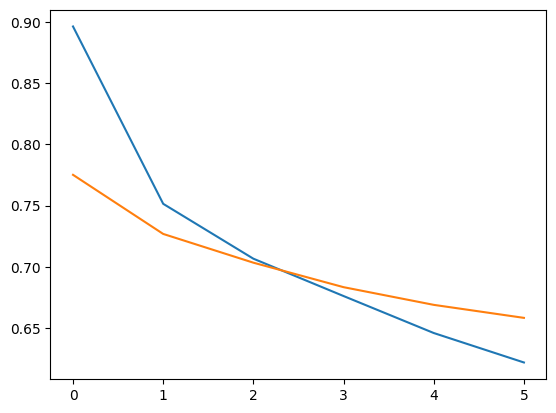

In [35]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation Section

In [36]:
%%time
from tqdm.auto import tqdm

prediction = []
for x in tqdm(tf_test_set):
  prediction += list(np.argmax(model(x[0])[0],axis=1))

actual_labels = data['test']['label']

  0%|          | 0/592 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


CPU times: user 2min 7s, sys: 826 ms, total: 2min 8s
Wall time: 2min 9s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,prediction))

F1-Score 0.7196003127902334
Precision-Score 0.7299895231498298
Recall-Score 0.717970401691332
accuracy_Score 0.717970401691332


**Plotting Confusion Matrix**

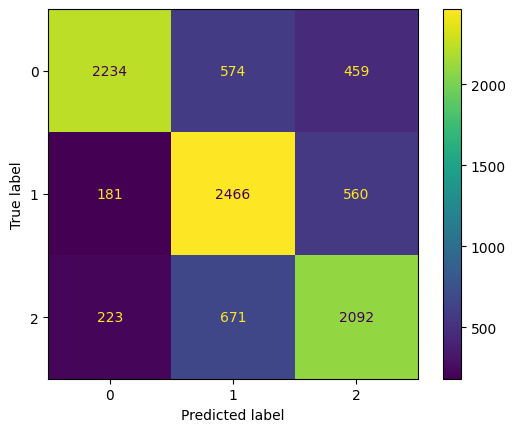

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=3).numpy())
cmd.plot()